In [1]:
import os
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb1
from xgboost.sklearn import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import *
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
# to make this notebook's output stable across runs
np.random.seed(666)

In [2]:
_data = pd.read_csv(r'D:\文档\kaggle\coding\数据科学-datawhale\data.csv',engine='python') #4754*90
data = _data.copy()

In [3]:
(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4754 entries, 0 to 4753
Data columns (total 90 columns):
Unnamed: 0                                    4754 non-null int64
custid                                        4754 non-null int64
trade_no                                      4754 non-null object
bank_card_no                                  4754 non-null object
low_volume_percent                            4752 non-null float64
middle_volume_percent                         4752 non-null float64
take_amount_in_later_12_month_highest         4754 non-null int64
trans_amount_increase_rate_lately             4751 non-null float64
trans_activity_month                          4752 non-null float64
trans_activity_day                            4752 non-null float64
transd_mcc                                    4752 non-null float64
trans_days_interval_filter                    4746 non-null float64
trans_days_interval                           4752 non-null float64
regional_mobility

In [4]:
#第一列没有列名,且为index项,删除
data.drop([data.columns[0]], axis=1, inplace=True)


In [5]:
#统计每列的缺失值个数, 并对其进行降序排列
data.isnull().sum().sort_values(ascending=False)

student_feature                               2998
cross_consume_count_last_1_month               426
query_org_count                                304
query_cash_count                               304
latest_six_month_apply                         304
latest_three_month_apply                       304
latest_query_time                              304
query_sum_count                                304
latest_one_month_apply                         304
query_finance_count                            304
apply_credibility                              304
apply_score                                    304
latest_query_day                               304
latest_one_month_loan                          297
loans_score                                    297
loans_credibility_behavior                     297
loans_count                                    297
loans_settle_count                             297
loans_overdue_count                            297
loans_org_count_behavior       

In [6]:
#'student_feature' 这列考虑删除, 或者将NA以0填充
data[['student_feature', 'status']].groupby(data['status']).count()

,student_feature,status
status,,
0,1307,3561
1,449,1193


In [7]:
#根据上面显示student_feature,应该与status是非常弱相关.所以删除,corr可以查看
data.drop(['student_feature'], axis=1, inplace=True)
#数据NA具有同一数据性,比如上面有大量297 304NA数据,他们也通常出自于相同也数据,也就是
#大量304NA数据出自于304个数据

In [8]:
#先自主浏览一下csv文件 肉眼识别需要删除文件
#1.查找所有dtype为object的列, 看是否需要删除
for i in range(len(data.columns)):
    if (data[data.columns[i]]).dtype == 'object':
        print(data.columns[i])

trade_no
bank_card_no
reg_preference_for_trad
source
id_name
latest_query_time
loans_latest_time


In [9]:
#删除不需要的列,object剩余trade_no, reg_preference_for_trad,latest_query_time,loans_latest_time
columns_delete = ['bank_card_no', 'source', 'id_name', 'custid']
data.drop(columns_delete, axis=1, inplace=True)

In [10]:
#有级别含义才需要labelencoder,否则使用onehot
print(data['reg_preference_for_trad'].unique())
data['reg_preference_for_trad'].value_counts()#使用onehot编码 4754个数据,含有两个NA数据

['一线城市' '三线城市' '境外' '二线城市' '其他城市' nan]


一线城市    3403
三线城市    1064
境外       150
二线城市     131
其他城市       4
Name: reg_preference_for_trad, dtype: int64

In [11]:
#处理缺失值,用众数填充 mode()[0]!!!!
data['reg_preference_for_trad'].fillna(data['reg_preference_for_trad'].mode()[0],inplace = True)
data['reg_preference_for_trad'].value_counts()

一线城市    3405
三线城市    1064
境外       150
二线城市     131
其他城市       4
Name: reg_preference_for_trad, dtype: int64

In [12]:
#使用onehot编码 4754个数据
data = data.join(pd.get_dummies(data['reg_preference_for_trad']))
data.drop(['reg_preference_for_trad'],axis = 1,inplace = True)

In [13]:
#将object修改为float
data['trade_no'] = data['trade_no'].astype(float)

In [14]:
#将时间序列object 修改为 时间序列
data['latest_query_time'] = pd.to_datetime(data['latest_query_time'], format='%Y-%m-%d %H:%M:%S.%f')
data['loans_latest_time'] = pd.to_datetime(data['loans_latest_time'], format='%Y-%m-%d %H:%M:%S.%f')

In [15]:
#将时间序列 修改为int
import datetime
a = (datetime.datetime.today() - data['loans_latest_time'])
b = map(lambda a:a.days, a)
data['loans_latest_time'] = pd.Series(b)


a = (datetime.datetime.today() - data['latest_query_time'])
b = map(lambda a:a.days, a)
data['latest_query_time'] = pd.Series(b)


In [16]:
#筛选无关特征，相关系数
corr=data.corr()
corr_1=np.abs(corr['status'])
corr_1.sort_values(ascending=False)

status                                     1.000000
trans_fail_top_count_enum_last_1_month     0.332256
history_fail_fee                           0.320033
loans_overdue_count                        0.279125
loans_score                                0.259092
latest_one_month_fail                      0.257269
apply_score                                0.244200
rank_trad_1_month                          0.147258
latest_one_month_suc                       0.138144
trans_fail_top_count_enum_last_6_month     0.133477
trans_fail_top_count_enum_last_12_month    0.117161
top_trans_count_last_1_month               0.117113
consfin_avg_limit                          0.091101
consfin_credit_limit                       0.083844
trans_day_last_12_month                    0.078892
avg_price_top_last_12_valid_month          0.071874
trans_top_time_last_1_month                0.068591
consume_top_time_last_1_month              0.066371
consfin_max_limit                          0.063307
latest_six_m

In [17]:
#trade_no 弱相关 剔除
data.drop(['trade_no'],axis = 1,inplace = True)

In [18]:
#统计每列的缺失值个数, 并对其进行降序排列 用keys获取列名
data.isnull().sum().sort_values(ascending=False)[:5]

cross_consume_count_last_1_month    426
query_org_count                     304
query_cash_count                    304
latest_six_month_apply              304
latest_one_month_apply              304
dtype: int64

In [19]:
#针对有缺失值的列看其相关性,相关性低,删除列
corr_1.sort_values(ascending=False)[data.isnull().sum().sort_values(ascending=False).keys()[:43]].sort_values(ascending=False)

history_fail_fee                     0.320033
loans_overdue_count                  0.279125
loans_score                          0.259092
latest_one_month_fail                0.257269
apply_score                          0.244200
latest_one_month_suc                 0.138144
consfin_avg_limit                    0.091101
consfin_credit_limit                 0.083844
avg_price_top_last_12_valid_month    0.071874
consfin_max_limit                    0.063307
latest_six_month_loan                0.062565
latest_query_time                    0.059539
latest_query_day                     0.059274
query_cash_count                     0.054786
latest_three_month_loan              0.053082
loans_count                          0.048211
consfin_product_count                0.035339
consfin_org_count_current            0.032000
consfin_org_count_behavior           0.032000
history_suc_fee                      0.030332
latest_one_month_loan                0.030005
loans_org_count_behavior          

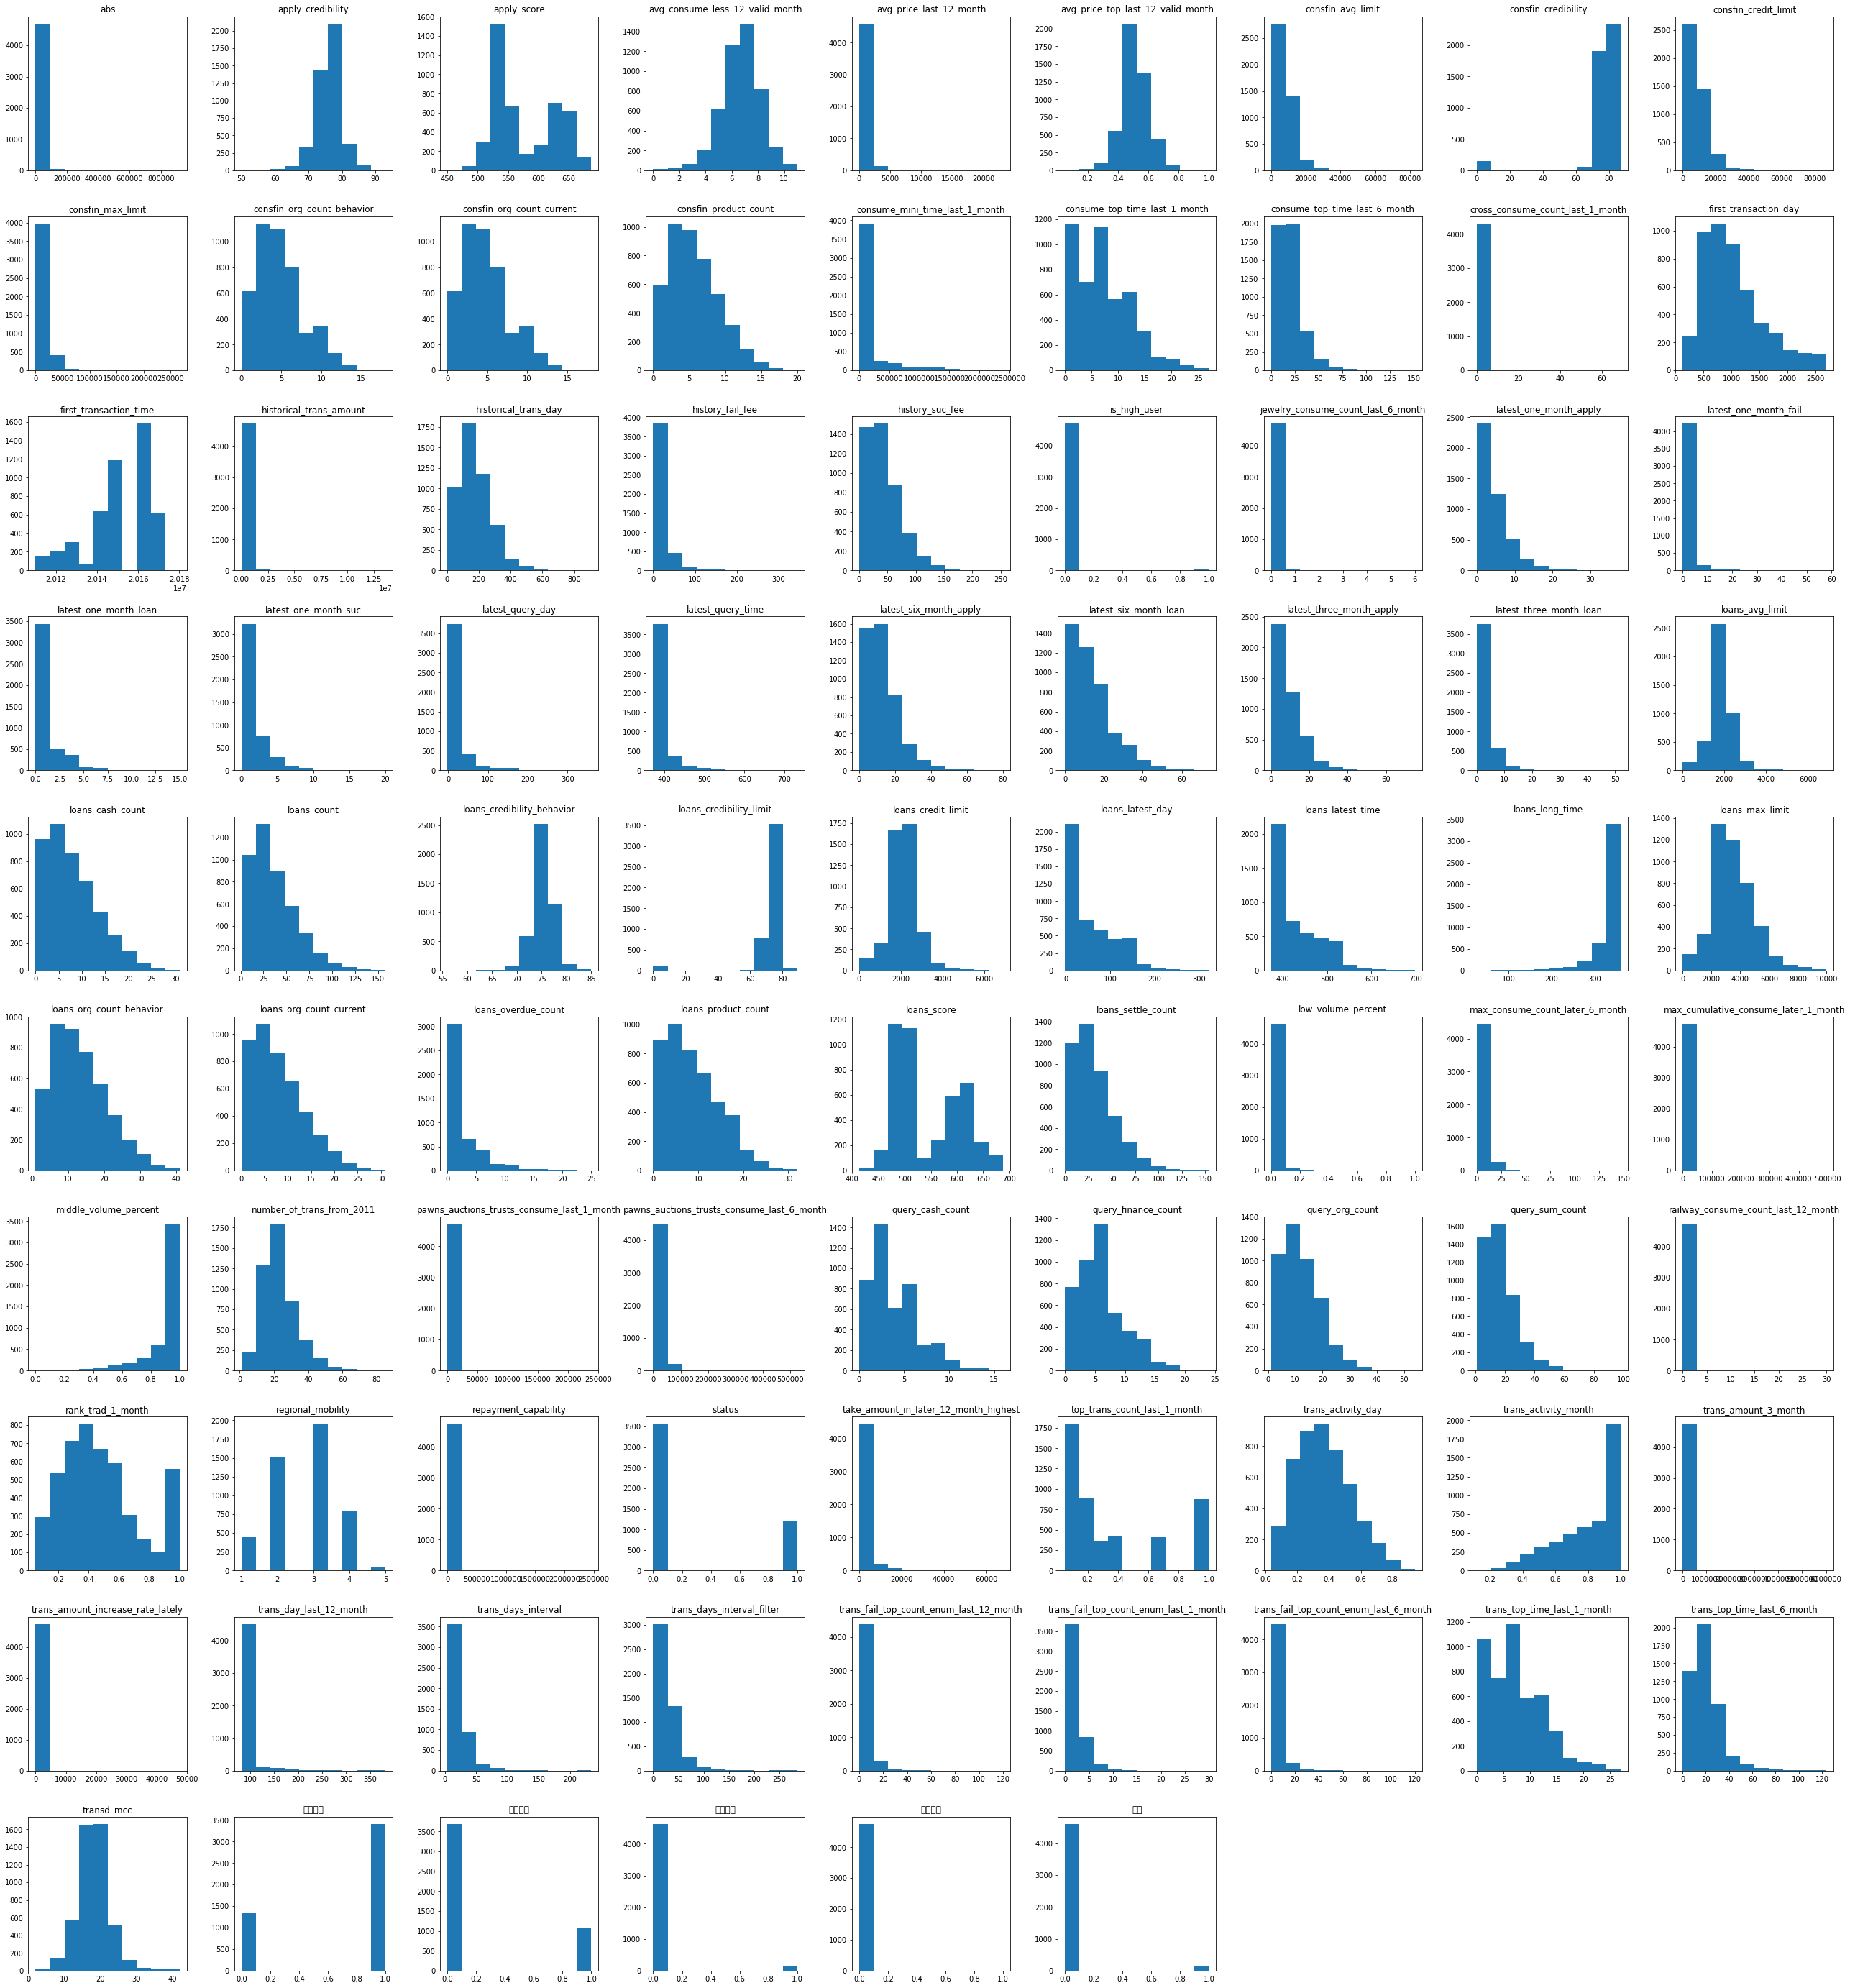

In [20]:
#查看数据分布, 偏态分布  不适合均值填充
data.hist(figsize=(45, 50), grid=False)
plt.show()

In [21]:
#用中值进行填充,由于特征太多后面还是建议删除弱相关特征,暂时先不操作,且感觉用中值填充也不太好

for i in data.keys():
    data[i].fillna(data[i].median(), inplace=True)
data.isnull().sum().sort_values(ascending=False)

境外                                            0
consume_mini_time_last_1_month                0
trans_top_time_last_1_month                   0
trans_top_time_last_6_month                   0
consume_top_time_last_1_month                 0
consume_top_time_last_6_month                 0
cross_consume_count_last_1_month              0
trans_fail_top_count_enum_last_1_month        0
trans_fail_top_count_enum_last_6_month        0
trans_fail_top_count_enum_last_12_month       0
max_cumulative_consume_later_1_month          0
avg_price_last_12_month                       0
max_consume_count_later_6_month               0
railway_consume_count_last_12_month           0
pawns_auctions_trusts_consume_last_1_month    0
pawns_auctions_trusts_consume_last_6_month    0
jewelry_consume_count_last_6_month            0
status                                        0
first_transaction_day                         0
trans_day_last_12_month                       0
avg_price_top_last_12_valid_month       

In [22]:
y = data['status']
data.drop(['status'], axis=1, inplace=True)
x = data

In [23]:
from sklearn.model_selection import *
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.7,random_state=666, stratify=np.array(y))

In [24]:
#这次是为了找feature_importance_ 所以先不上网格搜索,大致感受一下准确率  poly 还没用,随机森立不需要..
from sklearn.preprocessing import *
from sklearn.ensemble import *
std = StandardScaler()
std.fit(x_train)
x_train_std = std.transform(x_train)
x_test_std = std.transform(x_test)

In [25]:
random_forest = RandomForestClassifier(n_estimators=250, max_depth=4, n_jobs=-1, oob_score=True, random_state=666, verbose=1)
random_forest.fit(x_train_std, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.2s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=-1, oob_score=True, random_state=666, verbose=1,
                       warm_start=False)

In [26]:
random_forest.oob_score_

0.7811842500751428

In [27]:
random_forest.score(x_test_std, y_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    0.0s finished


0.7722494744218641

In [28]:
#观察一下 y的分布,  也就是瞎猜都是0也有75%的准确率. 然而上面准确率也有77%
#所以应该用recall 和precision F1 score
sum(y)/len(y)

0.2509465713083719

In [29]:
y_pred = random_forest.predict(x_test_std)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    0.0s finished


In [30]:
from sklearn.metrics import *
F1 = f1_score(y_test, y_pred)
F1

0.22062350119904076

In [31]:
#根据贷款逾期 这个说法 选择 recall为标准最好, 而是recall水平相当低 ...非常弱的分类器
recall_score(y_test, y_pred)

0.12849162011173185

In [32]:
precision_score(y_test, y_pred)

0.7796610169491526

In [33]:
#结果不太行...弱分类器 需要改进
random_forest.feature_importances_

array([0.00206511, 0.00304747, 0.00155322, 0.00398847, 0.00210729,
       0.00560924, 0.00273523, 0.00380286, 0.002759  , 0.00082211,
       0.00345418, 0.        , 0.00275215, 0.00584839, 0.01152387,
       0.00663224, 0.01534058, 0.01383316, 0.00145263, 0.0033193 ,
       0.00575582, 0.00502987, 0.00287823, 0.01264139, 0.00216645,
       0.01147181, 0.00387544, 0.00028196, 0.12672803, 0.02824173,
       0.02569775, 0.0029626 , 0.02152739, 0.0009693 , 0.00014186,
       0.00517033, 0.00586208, 0.        , 0.00453598, 0.01700264,
       0.08022161, 0.00247232, 0.00223872, 0.00219703, 0.00188498,
       0.00207329, 0.00623677, 0.00339126, 0.00404163, 0.00361911,
       0.11065282, 0.00166583, 0.00547898, 0.00434063, 0.07642847,
       0.00327308, 0.00227626, 0.00223697, 0.00140034, 0.00571037,
       0.00525837, 0.00397442, 0.11886812, 0.02323971, 0.0942717 ,
       0.00199004, 0.00411613, 0.00198362, 0.00153831, 0.00256804,
       0.00264725, 0.00253299, 0.00429092, 0.00459945, 0.00107

In [34]:
#取>0.01的(自我感觉), 也就是前16个
sum(np.array(sorted(random_forest.feature_importances_)[::-1])>0.01)

16

In [35]:
index = random_forest.feature_importances_.argsort()[::-1][:16]
index

array([28, 62, 50, 64, 40, 54, 29, 30, 63, 32, 39, 16, 17, 23, 14, 25],
      dtype=int64)

In [52]:
#通过random_forest 应该留下的特征名字
random_forest_feature = x.columns[index]
random_forest_feature

Index(['trans_fail_top_count_enum_last_1_month', 'history_fail_fee',
       'loans_score', 'latest_one_month_fail', 'apply_score',
       'loans_overdue_count', 'trans_fail_top_count_enum_last_6_month',
       'trans_fail_top_count_enum_last_12_month', 'latest_one_month_suc',
       'max_cumulative_consume_later_1_month', 'trans_day_last_12_month',
       'rank_trad_1_month', 'trans_amount_3_month',
       'trans_top_time_last_1_month', 'historical_trans_amount',
       'consume_top_time_last_1_month'],
      dtype='object')

In [55]:
x_random_forest_feature = x[random_forest_feature]

In [37]:
#定义计算iv值的函数  借鉴
#这里的缺陷是没有对连续变量进行分区域判断, 把连续变量也当做是离散变量,使用了unique
def calc_iv(df, feature, y, pr=False):
    """
    Set pr=True to enable printing of output.

    Output:
      * iv: float,
      * data: pandas.DataFrame
    """
    lst = []

    for i in range(df[feature].nunique()):  # nuinque()是查看该序列(axis=0/1对应着列或行)的不同值的数量个数
        val = list(df[feature].unique())[i]
        lst.append([feature,
                    val,  # Value
                    df[df[feature] == val].count()[feature],  # 值为val 的总个数
                    df[(df[feature] == val) & (y == 0)].count()[feature],  # val为0的总个数
                    df[(df[feature] == val) & (y == 1)].count()[feature]])  # val为1的总个数
    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])

    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])

    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print("IV = ", data['IV'].sum())

    iv = data['IV'].sum()

    return iv, data



In [59]:
#借鉴
column_headers = list(x.columns.values)


d=[]
for i in column_headers:
    IV_1, data_1 = calc_iv(x, i, y)
    d.append(IV_1)
#整理成Series类型并合并
column_headers=pd.Series(column_headers,name='feature')
d=pd.Series(d,name='iv_value')


iv_result=pd.concat([column_headers,d],axis=1)
iv_result.sort_values(by='iv_value',ascending=False)



d:\python\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning:

divide by zero encountered in log



,feature,iv_value
50,loans_score,0.615595
28,trans_fail_top_count_enum_last_1_month,0.598137
62,history_fail_fee,0.507044
40,apply_score,0.488201
13,first_transaction_time,0.486122
38,first_transaction_day,0.486122
10,repayment_capability,0.439096
32,max_cumulative_consume_later_1_month,0.395649
54,loans_overdue_count,0.387895
19,abs,0.372721


In [58]:
#通过iv值应该留下的特征

#在机器学习的二分类问题中，IV值（Information Value）主要用来对输入变量进行编码和预测能力评估。
#特征变量IV值的大小即表示该变量预测能力的强弱。IV 值的取值范围是[0, 正无穷)，如果当前分组中只包含响应客户或者未响应客户时，IV = 正无穷。 
#量化指标含义如下：< 0.02useless for prediction、0.02 to 0.1Weak predictor、0.1 to 0.3Medium predictor、
#0.3 to 0.5Strong predictor 、>0.5 Suspicious or too good to be true。
iv_feature = iv_result[iv_result['iv_value']>=0.02]['feature']
x_iv_feature = x[iv_feature]
x_iv_feature

,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,transd_mcc,trans_days_interval_filter,trans_days_interval,repayment_capability,...,loans_max_limit,loans_avg_limit,consfin_credit_limit,consfin_credibility,consfin_org_count_current,consfin_product_count,consfin_max_limit,consfin_avg_limit,latest_query_day,loans_latest_day
0,0.01,0.99,0,0.90,0.55,0.313,17.0,27.0,26.0,19890,...,2900.0,1688.0,1200.0,75.0,1.0,2.0,1200.0,1200.0,12.0,18.0
1,0.02,0.94,2000,1.28,1.00,0.458,19.0,30.0,14.0,16970,...,3500.0,1758.0,15100.0,80.0,5.0,6.0,22800.0,9360.0,4.0,2.0
2,0.04,0.96,0,1.00,1.00,0.114,13.0,68.0,22.0,9710,...,1600.0,1250.0,4200.0,87.0,1.0,1.0,4200.0,4200.0,2.0,6.0
3,0.00,0.96,2000,0.13,0.57,0.777,22.0,14.0,6.0,6210,...,3200.0,1541.0,16300.0,80.0,5.0,5.0,30000.0,12180.0,2.0,4.0
4,0.01,0.99,0,0.46,1.00,0.175,13.0,66.0,42.0,11150,...,2300.0,1630.0,8300.0,79.0,2.0,2.0,8400.0,8250.0,22.0,120.0
5,0.02,0.98,2000,7.59,1.00,0.733,27.0,8.0,11.0,8420,...,5300.0,1941.0,11200.0,80.0,10.0,12.0,20400.0,8130.0,3.0,4.0
6,0.02,0.98,0,23.67,0.94,0.087,10.0,54.0,53.0,11220,...,2200.0,2200.0,7600.0,73.0,2.0,2.0,16800.0,8900.0,1.0,3.0
7,0.02,0.98,0,0.25,0.88,0.302,19.0,20.0,20.0,8220,...,3100.0,1810.0,7700.0,79.0,4.0,5.0,13800.0,7050.0,14.0,36.0
8,0.03,0.65,0,0.31,0.76,0.472,15.0,21.0,14.0,69800,...,5300.0,4750.0,5500.0,79.0,8.0,11.0,19200.0,7987.0,24.0,7.0
9,0.01,0.99,500,0.80,1.00,0.088,15.0,36.0,35.0,12510,...,2800.0,1520.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,142.0
